In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

In [9]:
# load data
df = pd.read_csv("../data/cleaned/cleaned_nigeria_medical_insurance.csv")

numerical_features = ["age", "bmi", "children"]
categorical_features = ["gender", "smoker", "state"]

target_column = "hospital_bill"

X = df[numerical_features + categorical_features]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
print("\nTraining set size", X_train.shape[0])
print("Testing set size", X_test.shape[0])
print("\nTraining set price range {:.2f} - {:.2f}".format(
    float(y_train.min()), float(y_train.max())
))
print("\nTesting set price range {:.2f} - {:.2f}".format(
    float(y_test.min()), float(y_test.max())
))



Training set size 741
Testing set size 186

Training set price range 1697259.90 - 95655642.02

Testing set price range 1712168.00 - 87856611.72


In [12]:
# loading models
lr = joblib.load("../models/lr_model_pipeline.pkl")
rf = joblib.load("../models/rf_model_pipeline.pkl")
xg = joblib.load("../models/xg_model_pipeline.pkl")

# fit models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('xgregressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transform

In [13]:
def evaluate_model(model, X_test, y_test):
    
    predictions = model.predict(X_test)
    
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    rms = np.sqrt(np.mean(predictions**2)) 
    
    return r2, mse, rmse, rms, predictions

In [15]:
results = {}

for name, model in {
    "Linear Regression": lr,
    "Random Forest Regression": rf,
    "XGBoost": xg
}.items():
    
    r2, mse, rmse, rms, preds = evaluate_model(model, X_test, y_test)
    
    results[name] = {
        "R2 Score": r2,
        "MSE": mse,
        "RMSE": rmse,
        "RMS": rms
    }
    
    print(f"\n{name}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"RMS: {rms:.2f}")


Linear Regression
R2 Score: 0.0902
MSE: 264088073007341.84
RMSE: 16250786.84
RMS: 20632741.64

Random Forest
R2 Score: 0.0481
MSE: 276307290503988.38
RMSE: 16622493.51
RMS: 20532170.34

XGBoost
R2 Score: 0.0669
MSE: 270866107312201.81
RMSE: 16458010.43
RMS: 20683990.00


In [16]:
results_df = pd.DataFrame(results).T
results_df

,R2 Score,MSE,RMSE,RMS
Linear Regression,0.090212,2.640881e+14,1.625079e+07,2.063274e+07
Random Forest,0.048116,2.763073e+14,1.662249e+07,2.053217e+07
XGBoost,0.066861,2.708661e+14,1.645801e+07,2.068399e+07


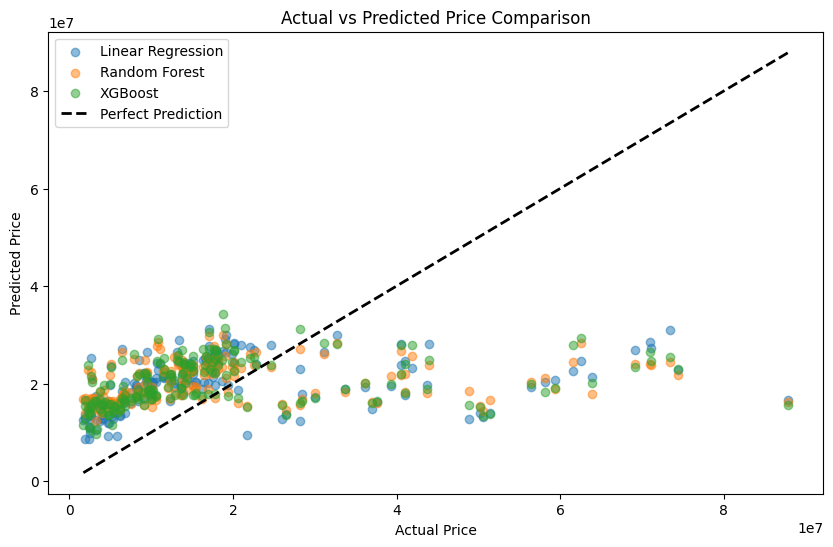

In [19]:
plt.figure(figsize=(10,6))

# Predict again for plotting
lr_preds = lr.predict(X_test)
rf_preds = rf.predict(X_test)
xg_preds = xg.predict(X_test)

plt.scatter(y_test, lr_preds, alpha=0.5, label="Linear Regression")
plt.scatter(y_test, rf_preds, alpha=0.5, label="Random Forest")
plt.scatter(y_test, xg_preds, alpha=0.5, label="XGBoost")

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2, label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price Comparison")
plt.legend()
plt.show()

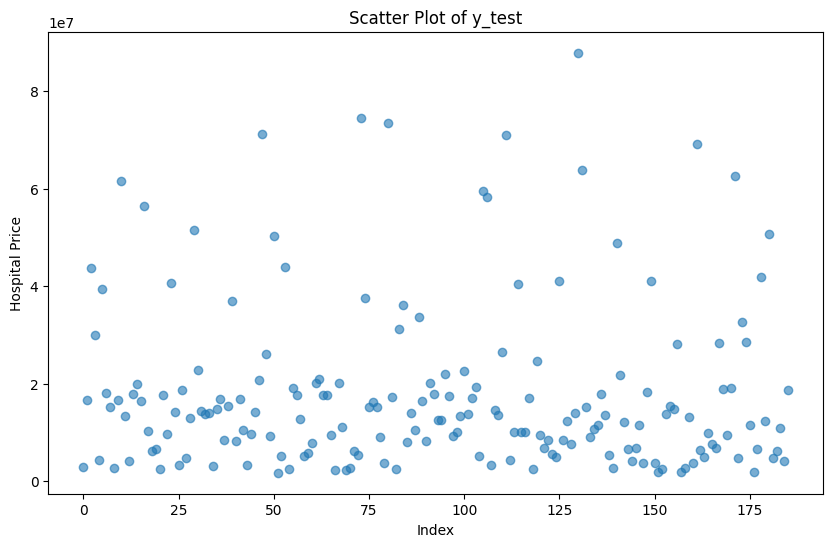

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(range(len(y_test)), y_test, alpha=0.6)

plt.xlabel("Index")
plt.ylabel("Hospital Price")
plt.title("Scatter Plot of y_test")
plt.show()